In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
import random
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#In this notebook I'll load EPlus simulation output
#output the building's various components
#print each building's components to map which buildings to compare

In [4]:
class nnet(nn.Module):
    #linear model for kernelized inputs
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.D_out)
    
    def forward(self, x):
        x = self.l1(x) #linear weights for model interpretability
        return(x)

## EPlus

In [5]:
#features to ignore"
ignore = ["Performance Curve Input Variable 1 Value [] !Each Call", "Performance Curve Output Value [] !Each Call"]

#def parse_line()

def read_data_dictionary(lines):
    data_dict = {}
    for line in lines:
        l = line.strip()
        if l == "End of Data Dictionary":
            break
        else:
            tokens = l.split(",")
            if int(tokens[0]) == 2:
                data_dict[int(tokens[0])] = tokens[1:]
                #parse time dictionary line
            elif int(tokens[0]) > 6 and int(tokens[1]) == 1:
                if tokens[-1] in ignore:
                    pass
                elif len(tokens) == 4:
                    data_dict[int(tokens[0])] = tokens[-2] + tokens[-1]
                    
                else:
                    #parse value dictionary line
                    data_dict[int(tokens[0])] = tokens[-1]
            else:
                pass
    return(data_dict)

def parse_time_line(line_str):
    #2,8,Day of Simulation[],Month[],Day of Month[],DST Indicator[1=yes 0=no],Hour[],StartMinute[],EndMinute[],DayType
    #2, 1, 1, 1, 0, 1, 0.00, 2.00, Holiday
    #only want hourly times, multiple minute 2's, assuming got correct
    tokens = line_str.strip().split(",")
    minute=float(tokens[-3])
    hour=int(tokens[-4])
    day=int(tokens[-6])
    month=int(tokens[-7])
    return(datetime.datetime(2017, month, day, hour-1, 0, 0)) #2017 so that the 1st is a Sunday + not leapyear
    #return(str(month) + "/" + str(day) + " " + str(hour) + ":00")
     
def parse_lines(lines, feature_inds):
    data_values = {}
    data_values[2] = []
    for i in feature_inds:
        data_values[i] = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                data_values[2].append(t)
        elif int(tokens[0]) in feature_inds:
            data_values[int(tokens[0])].append(float(tokens[-1]))
        else:
            pass
    return(data_values)
    #return hourly list for all feature vars, plus hourly list with times to check sorting
    
def get_holidays(lines):
    holidays = []
    weekends = []
    all_dates = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if tokens[-1] == "Holiday":
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                holidays.append(t)
        elif int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                all_dates.append(t)
                if t.weekday() == 6 or t.weekday() == 0:
                    weekends.append(t)
    return(all_dates, weekends, holidays)
                      
def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def read_total_data_array(filepath, dep_var_names, ind_var_names, zone_temp_inds, first_diff=False, no_weekend_holiday=False):
    with open(datapath + filepath) as d:
        lines = d.readlines()
        lines.pop(0)
        data_dict = read_data_dictionary(lines)
        data = parse_lines(lines, data_dict)
        all_dates, weekends, holidays = get_holidays(lines)
        ind_map = {}
        for key, value in data_dict.items():
            if type(value) == list:
                value = value[-1]
            ind_map[value] = key

    X = np.zeros((len(dep_var_names) + len(zone_temp_inds), 8760))
    U = np.zeros((len(ind_var_names), 8760))

    for i in range(len(ind_var_names)):
        item = ind_var_names[i]
        ind = ind_map[item]
        if item == 'DayType':
            lis = data[ind]
            out = []
            for val in lis:
                out.append(val.weekday()/7.0)
            arr = np.array(out)
        else:
            arr = np.array(data[ind])
        U[i,:] = arr

    for j in range(len(dep_var_names)):
        item = dep_var_names[j]
        ind = ind_map[item]
        arr = np.array(data[ind])
        X[j,:] = arr

    for j in range(len(zone_temp_inds)):
        ind = zone_temp_inds[j]
        arr = np.array(data[ind])
        X[j+len(dep_var_names),:] = arr
        
    if no_weekend_holiday == True:
        weekend_i = []
        holiday_i = []
        for j in range(len(all_dates)):
            if all_dates[j] in weekends:
                weekend_i.append(j)
            if all_dates[j] in holidays:
                holiday_i.append(j)
                
        del_i = np.array(list(set(holiday_i + weekend_i)))
        X = np.delete(X, del_i, axis=1)
        U = np.delete(U, del_i, axis=1)
    
    if first_diff == True:
        X = np.diff(X, n=1, axis=1)
        U = np.diff(U, n=1, axis=1)

    Z = np.vstack((X, U))

    return(Z, X, U)

def split_train_val(Z, X, U, order=1, shuff=True, split_prop=0.8):
    all_pairs = []
    for i in range(Z.shape[1] - order):  #not 8760 for first-diff
        all_pairs.append((Z[:,i:i+order-1].flatten(), Z[0:-U.shape[0],i+order]))

    if shuff == True:
        random.shuffle(all_pairs) 
    else:
        pass

    train_pairs = all_pairs[0:int(split_prop*len(all_pairs))]
    val_pairs = all_pairs[-int((1.0-split_prop)*len(all_pairs)):]
    
    #normalize to training data
    X_train = []
    Y_train = []

    for item in train_pairs:
        X_train.append(item[0])
        Y_train.append(item[1])

    X_val = []
    Y_val = []
    for item in val_pairs:
        X_val.append(item[0])
        Y_val.append(item[1])

    X_train = np.asarray(X_train).T
    Y_train = np.asarray(Y_train).T

    X_val = np.asarray(X_val).T
    Y_val = np.asarray(Y_val).T
    
    return(X_train, Y_train, X_val, Y_val)

def normalize_data_set(X, Y, X_minmax_vals):
    X_norm = copy.copy(X)
    Y_norm = copy.copy(Y)
    
    for row in range(X.shape[0]):
        mx = np.max(X_minmax_vals[row,:])
        mn = np.min(X_minmax_vals[row,:])

        X_norm[row,:] = (1.0/(mx - mn))*(X[row,:] - mn)

        if row < Y.shape[0]:
            Y_norm[row,:] = (1.0/(mx - mn))*(Y[row,:] - mn)
            
    return(X_norm, Y_norm)

def polynomial_kernel_mat(X, poly_degree):
    X_poly = np.zeros((X.shape[0]*poly_degree,X.shape[1]))
    for d in range(poly_degree):
        for row in range(X.shape[0]):
            X_poly[row + d*poly_degree,:] = np.power(X[row,:], d)
    return(X_poly)

def prepare_data(Z, X, U, order=1, shuff=True, split_prop=0.8, normalizer=False, norm_mat=""):
    X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=shuff, split_prop=split_prop)

    if not normalizer:
        X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
        X_val, Y_val = normalize_data_set(X_val_pre, Y_val_pre, X_train_pre)
    else:
        X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, norm_mat)
        X_val, Y_val = normalize_data_set(X_val_pre, Y_val_pre, norm_mat)        

    X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
    X_val_poly = polynomial_kernel_mat(X_val, poly_degree)
    
    return(X_train_poly, Y_train, X_val_poly, Y_val)

In [6]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly', 'DayType']

poly_degree = 3
order = 26

#simple order is just previous time step
ext_order = [0, 1, 9 , 10, 11, 17, 25]

#to test:
#"""
#from statsmodels.graphics.tsaplots import plot_pacf
#plot_pacf(data[1922], lags=40, alpha=0.05)
#plt.show()
#"""

### Medium Office Building

In [7]:
#building specific var names

zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_pre_norm = split_train_val(Z, X, U, order=order, shuff=False, split_prop=0.8)[0]

X_train_med_poly, Y_train_med, X_val_med_poly, Y_val_med = prepare_data(Z, X, U, order=order, shuff=False, split_prop=0.8)

In [8]:
Z.shape

(9, 6407)

In [9]:
print(X_med_pre_norm.shape, X_train_med_poly.shape)

(225, 5104) (675, 5104)


In [10]:
params = {'FEATURE_DIM': 9*(order-1)*poly_degree, 'OUTPUT_DIM': 6}
net = nnet(params)
loss_func = nn.SmoothL1Loss()#MSELoss()
optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
epochs = 1000
batch_size = 100

In [83]:
for e in range(epochs):
    print("Epoch: ", e)
    training_losses = []
    for k in range(int(X_train_med_poly.shape[1]/batch_size)):
        inp = Variable(torch.Tensor(X_train_med_poly[:,k*batch_size:(k+1)*batch_size].T))
        label = Variable(torch.Tensor(Y_train_med[:,k*batch_size:(k+1)*batch_size].T))
        
        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.data[0])
        
    print("Training loss: ", np.mean(training_losses))
    
    inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    label_val = Variable(torch.Tensor(Y_val_med.T))
    out_val = net(inp_val)
    loss_val = loss_func(out_val, label_val)
    
    print("Validation loss:", loss_val)

Epoch:  0
Training loss:  0.010668465
Validation loss: tensor(0.0010, grad_fn=<SmoothL1LossBackward>)
Epoch:  1
Training loss:  0.0007966551
Validation loss: tensor(0.0007, grad_fn=<SmoothL1LossBackward>)
Epoch:  2
Training loss:  0.0007456264
Validation loss: tensor(0.0007, grad_fn=<SmoothL1LossBackward>)
Epoch:  3
Training loss:  0.0007238488
Validation loss: tensor(0.0007, grad_fn=<SmoothL1LossBackward>)
Epoch:  4
Training loss:  0.0007033719
Validation loss: tensor(0.0007, grad_fn=<SmoothL1LossBackward>)
Epoch:  5


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training loss:  0.0006840152
Validation loss: tensor(0.0007, grad_fn=<SmoothL1LossBackward>)
Epoch:  6
Training loss:  0.00066570623
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  7
Training loss:  0.0006483779
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  8
Training loss:  0.0006319681
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  9
Training loss:  0.00061641884
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  10
Training loss:  0.0006016759
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  11
Training loss:  0.0005876893
Validation loss: tensor(0.0006, grad_fn=<SmoothL1LossBackward>)
Epoch:  12
Training loss:  0.0005744123
Validation loss: tensor(0.0005, grad_fn=<SmoothL1LossBackward>)
Epoch:  13
Training loss:  0.0005618013
Validation loss: tensor(0.0005, grad_fn=<SmoothL1LossBackward>)
Epoch:  14
Training loss:  0.00054981594
Validation loss: tensor(0.0005, grad

Training loss:  0.00027747842
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  86
Training loss:  0.0002763267
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  87
Training loss:  0.00027519622
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  88
Training loss:  0.0002740863
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  89
Training loss:  0.00027299632
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  90
Training loss:  0.00027192562
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  91
Training loss:  0.0002708736
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  92
Training loss:  0.0002698396
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  93
Training loss:  0.00026882323
Validation loss: tensor(0.0003, grad_fn=<SmoothL1LossBackward>)
Epoch:  94
Training loss:  0.0002678238
Validation loss: tensor(0.0003

Training loss:  0.00022219885
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  165
Training loss:  0.00022175162
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  166
Training loss:  0.00022130791
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  167
Training loss:  0.00022086766
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  168
Training loss:  0.00022043087
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  169
Training loss:  0.0002199974
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  170
Training loss:  0.00021956733
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  171
Training loss:  0.00021914054
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  172
Training loss:  0.00021871696
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  173
Training loss:  0.00021829661
Validation loss: 

Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  243
Training loss:  0.00019493174
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  244
Training loss:  0.0001946651
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  245
Training loss:  0.00019439998
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  246
Training loss:  0.00019413636
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  247
Training loss:  0.00019387416
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  248
Training loss:  0.00019361344
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  249
Training loss:  0.00019335415
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  250
Training loss:  0.00019309629
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  251
Training loss:  0.00019283987
Validation loss: tensor(0.0002, grad_fn=<Smooth

Training loss:  0.0001772941
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  325
Training loss:  0.0001771173
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  326
Training loss:  0.00017694132
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  327
Training loss:  0.00017676616
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  328
Training loss:  0.0001765918
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  329
Training loss:  0.00017641824
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  330
Training loss:  0.00017624542
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  331
Training loss:  0.00017607346
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  332
Training loss:  0.00017590226
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  333
Training loss:  0.00017573184
Validation loss: te

Training loss:  0.00016546708
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  404
Training loss:  0.00016534099
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  405
Training loss:  0.00016521533
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  406
Training loss:  0.00016509023
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  407
Training loss:  0.0001649656
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  408
Training loss:  0.00016484145
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  409
Training loss:  0.00016471774
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  410
Training loss:  0.00016459462
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  411
Training loss:  0.00016447192
Validation loss: tensor(0.0002, grad_fn=<SmoothL1LossBackward>)
Epoch:  412
Training loss:  0.00016434971
Validation loss: 

Training loss:  0.00015674447
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  484
Training loss:  0.0001566506
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  485
Training loss:  0.000156557
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  486
Training loss:  0.00015646378
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  487
Training loss:  0.00015637086
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  488
Training loss:  0.00015627827
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  489
Training loss:  0.00015618595
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  490
Training loss:  0.00015609396
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  491
Training loss:  0.00015600232
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  492
Training loss:  0.00015591098
Validation loss: te

Training loss:  0.00015005843
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  565
Training loss:  0.00014998608
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  566
Training loss:  0.00014991395
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  567
Training loss:  0.00014984203
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  568
Training loss:  0.0001497703
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  569
Training loss:  0.00014969884
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  570
Training loss:  0.00014962757
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  571
Training loss:  0.00014955648
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  572
Training loss:  0.00014948566
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  573
Training loss:  0.00014941499
Validation loss: 

Training loss:  0.00014494162
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  644
Training loss:  0.00014488376
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  645
Training loss:  0.00014482613
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  646
Training loss:  0.00014476856
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  647
Training loss:  0.00014471117
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  648
Training loss:  0.00014465395
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  649
Training loss:  0.00014459688
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  650
Training loss:  0.00014453998
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  651
Training loss:  0.00014448317
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  652
Training loss:  0.00014442655
Validation loss:

Training loss:  0.0001408491
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  722
Training loss:  0.00014080161
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  723
Training loss:  0.00014075423
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  724
Training loss:  0.00014070695
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  725
Training loss:  0.00014065982
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  726
Training loss:  0.00014061277
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  727
Training loss:  0.00014056587
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  728
Training loss:  0.00014051904
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  729
Training loss:  0.00014047232
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  730
Training loss:  0.00014042568
Validation loss: 

Training loss:  0.00013745575
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  800
Training loss:  0.00013741602
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  801
Training loss:  0.00013737631
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  802
Training loss:  0.00013733671
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  803
Training loss:  0.00013729719
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  804
Training loss:  0.00013725777
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  805
Training loss:  0.00013721843
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  806
Training loss:  0.00013717916
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  807
Training loss:  0.00013713997
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  808
Training loss:  0.00013710087
Validation loss:

Training loss:  0.00013459106
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  878
Training loss:  0.00013455721
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  879
Training loss:  0.00013452342
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  880
Training loss:  0.00013448972
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  881
Training loss:  0.00013445606
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  882
Training loss:  0.00013442244
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  883
Training loss:  0.00013438893
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  884
Training loss:  0.00013435548
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  885
Training loss:  0.00013432211
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  886
Training loss:  0.00013428878
Validation loss:

Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  960
Training loss:  0.00013199067
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  961
Training loss:  0.00013196173
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  962
Training loss:  0.00013193283
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  963
Training loss:  0.000131904
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  964
Training loss:  0.00013187519
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  965
Training loss:  0.00013184648
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  966
Training loss:  0.0001318178
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  967
Training loss:  0.00013178916
Validation loss: tensor(0.0001, grad_fn=<SmoothL1LossBackward>)
Epoch:  968
Training loss:  0.00013176053
Validation loss: tensor(0.0001, grad_fn=<SmoothL1

In [ ]:
### Baseline identity matrix

### Test number of samples required for convergence

In [11]:
validation_loss = []

for s in range(11,6000):
    print("Training data size: ", s)
    params = {'FEATURE_DIM': 9*(order-1)*poly_degree, 'OUTPUT_DIM': 6}
    net = nnet(params)
    loss_func = nn.SmoothL1Loss()#MSELoss()
    optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
    epochs = 100
    batch_size = 10
    
    X_train = X_train_med_poly[:,0:s]
    Y_train = Y_train_med[:,0:s]
    
    for e in range(epochs):
        training_losses = []
        for k in range(int(X_train.shape[1]/batch_size)):
            inp = Variable(torch.Tensor(X_train[:,k*batch_size:(k+1)*batch_size].T))
            label = Variable(torch.Tensor(Y_train[:,k*batch_size:(k+1)*batch_size].T))

            out = net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data[0])
    
    inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    label_val = Variable(torch.Tensor(Y_val_med.T))
    out_val = net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss.append(loss_val)

Training data size:  11
Training data size:  12
Training data size:  13
Training data size:  14
Training data size:  15


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training data size:  16
Training data size:  17
Training data size:  18
Training data size:  19
Training data size:  20
Training data size:  21
Training data size:  22
Training data size:  23
Training data size:  24
Training data size:  25
Training data size:  26
Training data size:  27
Training data size:  28
Training data size:  29
Training data size:  30
Training data size:  31
Training data size:  32
Training data size:  33
Training data size:  34
Training data size:  35
Training data size:  36
Training data size:  37
Training data size:  38
Training data size:  39
Training data size:  40
Training data size:  41
Training data size:  42
Training data size:  43
Training data size:  44
Training data size:  45
Training data size:  46
Training data size:  47
Training data size:  48
Training data size:  49
Training data size:  50
Training data size:  51
Training data size:  52
Training data size:  53
Training data size:  54
Training data size:  55
Training data size:  56
Training data si

KeyboardInterrupt: 

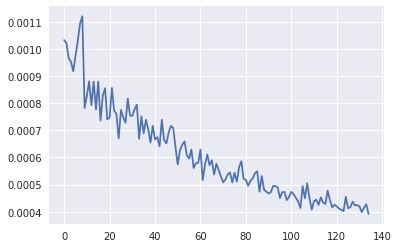

In [12]:
plt.plot(np.array(validation_loss))
plt.show()

In [47]:
validation_loss = []

for s in [10, 50, 100, 500, 1000, 1500, 2000, 2500, 5000]:
#for s in range(11,6000):
    print("Training data size: ", s)
    params = {'FEATURE_DIM': 9*(order-1)*poly_degree, 'OUTPUT_DIM': 6}
    net = nnet(params)
    loss_func = nn.SmoothL1Loss()#MSELoss()
    optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
    epochs = 100
    batch_size = 10
    
    X_train = X_train_med_poly[:,0:s]
    Y_train = Y_train_med[:,0:s]
    
    for e in range(epochs):
        training_losses = []
        for k in range(int(X_train.shape[1]/batch_size)):
            inp = Variable(torch.Tensor(X_train[:,k*batch_size:(k+1)*batch_size].T))
            label = Variable(torch.Tensor(Y_train[:,k*batch_size:(k+1)*batch_size].T))

            out = net(inp)
            optimizer.zero_grad()
            loss = loss_func(out, label)
            loss.backward()
            optimizer.step()
            training_losses.append(loss.data[0])
    
    inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    label_val = Variable(torch.Tensor(Y_val_med.T))
    out_val = net(inp_val)
    loss_val = loss_func(out_val, label_val)
    validation_loss.append(loss_val)

Training data size:  10
Training data size:  50
Training data size:  100


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training data size:  500
Training data size:  1000
Training data size:  1500
Training data size:  2000
Training data size:  2500
Training data size:  5000


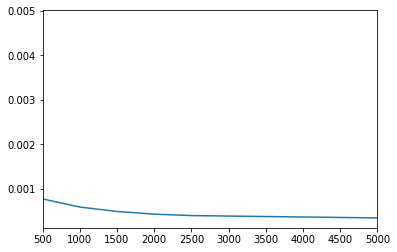

In [54]:
plt.plot(np.array([10, 50, 100, 500, 1000, 1500, 2000, 2500, 5000]), validation_loss)
plt.xlim(500,5000)
plt.show()

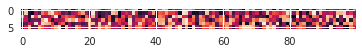

In [13]:
A = copy.copy(net.l1.weight.data.numpy())
plt.imshow(A[:,-100:])
plt.show()
#print(A)

In [85]:
np.mean(np.abs(label_val.detach().numpy() - out_val.detach().numpy()))

0.0069711856

In [86]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault, X_fault, U_fault = read_total_data_array("refbuild_med_airfault/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_poly, Y_med = prepare_data(Z, X, U, order=order, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault, X_fault, U_fault, order=order, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [87]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

In [88]:

print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.001243629697707729 0.0012621806472794502
0.0035640810486797523 0.004248395497158147


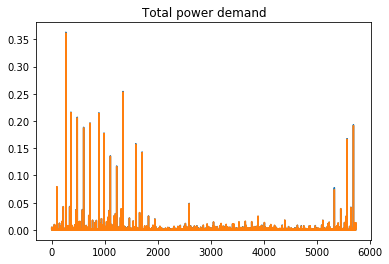

In [91]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

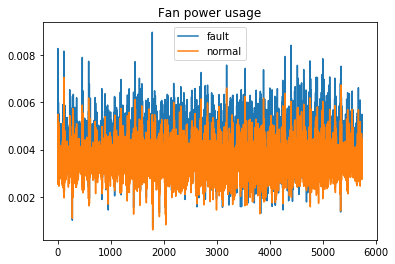

In [96]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [92]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault_deg, X_fault_deg, U_fault_deg = read_total_data_array("refbuild_med_airfaultdeg/seattle/Fault_FoulingAirFilter_RefBldgMediumOfficeNew2004.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_poly, Y_med = prepare_data(Z, X, U, order=order, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_deg, X_fault_deg, U_fault_deg, order=order, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [93]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

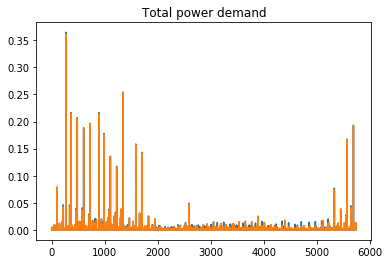

In [94]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

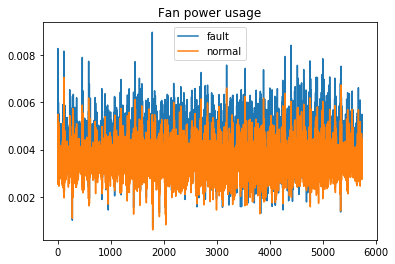

In [95]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [21]:
print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.004892881566654019 0.01186915207536639
0.000733371083587669 0.001424533350428605


In [97]:
 #building specific var names
zone_temp_inds = [863,864,865]

Z_fault_p, X_fault_p, U_fault_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_poly, Y_med = prepare_data(Z, X, U, order=order, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_p, X_fault_p, U_fault_p, order=order, shuff=False, split_prop=0.9, normalizer=True, norm_mat=X_med_pre_norm)[0:2]

In [98]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

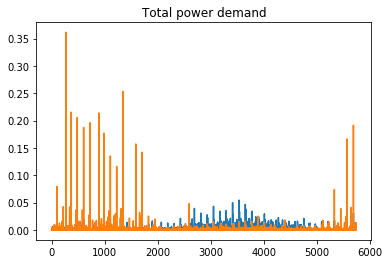

In [99]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

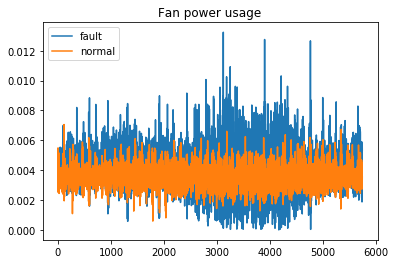

In [100]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

In [26]:
print(np.mean(e_lkhds), np.mean(e_lkhds_fault))
print(np.mean(f_lkhds), np.mean(f_lkhds_fault))

0.004892881566654019 0.04894890742817222
0.000733371083587669 0.0025446611375691064


In [27]:
#performance against identity
#number of samples to converge matrix
# --- control for temperature seasonality
# --- remove weekends holidays
# --- diferencing for stationary

# --- two ways to transfer: either bundle components or for unknown components set to 0 and bootstrap with blocks of known columns

### Rescaling is not enough

In [101]:
#building specific var names
zone_temp_inds = [863,864,865]

Z_fault_p, X_fault_p, U_fault_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_poly, Y_med = prepare_data(Z, X, U, order=order, shuff=False, split_prop=0.9)[0:2]
X_med_poly_fault, Y_med_fault = prepare_data(Z_fault_p, X_fault_p, U_fault_p, order=order, shuff=False, split_prop=0.9, normalizer=False)[0:2]

In [102]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

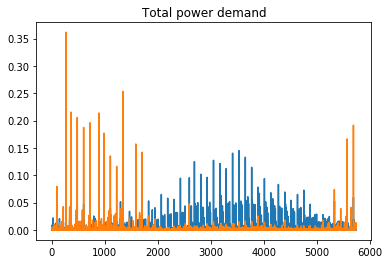

In [103]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

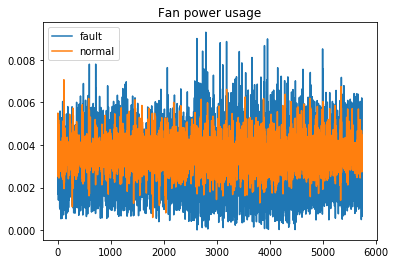

In [105]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

### Retrain for phoenix

In [107]:
#params = {'FEATURE_DIM': 9*poly_degree, 'OUTPUT_DIM': 6}
#net = nnet(params)
#loss_func = nn.SmoothL1Loss()#MSELoss()
#optimizer = optim.SGD(net.parameters(),lr=0.005, momentum=0.9)
epochs = 100
batch_size = 10

In [106]:
Z_p, X_p, U_p = read_total_data_array("refbuild_med/phoenix/Static_RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

X_med_pre_norm_p = split_train_val(Z_p, X_p, U_p, order=order, shuff=True, split_prop=0.2)[0]

X_train_med_poly_p, Y_train_med_p, X_val_med_poly_p, Y_val_med_p = prepare_data(Z_p, X_p, U_p, order=order, shuff=True, split_prop=0.2, norm_mat=X_med_pre_norm)

In [108]:
for e in range(epochs):
    print("Epoch: ", e)
    training_losses = []
    for k in range(int(X_train_med_poly_p.shape[1]/batch_size)):
        inp = Variable(torch.Tensor(X_train_med_poly_p[:,k*batch_size:(k+1)*batch_size].T))
        label = Variable(torch.Tensor(Y_train_med_p[:,k*batch_size:(k+1)*batch_size].T))
        
        out = net(inp)
        optimizer.zero_grad()
        loss = loss_func(out, label)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.data[0])
        
    print("Training loss: ", np.mean(training_losses))
    
    #no validation data available
    #inp_val = Variable(torch.Tensor(X_val_med_poly.T))
    #label_val = Variable(torch.Tensor(Y_val_med.T))
    #out_val = net(inp_val)
    #loss_val = loss_func(out_val, label_val)
    
    #print("Validation loss:", loss_val)

Epoch:  0
Training loss:  0.0007990897
Epoch:  1
Training loss:  0.0006233836
Epoch:  2
Training loss:  0.0005825803
Epoch:  3
Training loss:  0.00055454473
Epoch:  4
Training loss:  0.0005337999
Epoch:  5
Training loss:  0.0005175165
Epoch:  6
Training loss:  0.00050417375
Epoch:  7
Training loss:  0.0004929091
Epoch:  8
Training loss:  0.00048320016
Epoch:  9


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Training loss:  0.0004747077
Epoch:  10
Training loss:  0.0004671956
Epoch:  11
Training loss:  0.00046049035
Epoch:  12
Training loss:  0.00045445867
Epoch:  13
Training loss:  0.00044899512
Epoch:  14
Training loss:  0.00044401435
Epoch:  15
Training loss:  0.0004394469
Epoch:  16
Training loss:  0.00043523448
Epoch:  17
Training loss:  0.00043132945
Epoch:  18
Training loss:  0.00042769144
Epoch:  19
Training loss:  0.0004242866
Epoch:  20
Training loss:  0.00042108638
Epoch:  21
Training loss:  0.00041806672
Epoch:  22
Training loss:  0.00041520715
Epoch:  23
Training loss:  0.00041249013
Epoch:  24
Training loss:  0.00040990076
Epoch:  25
Training loss:  0.00040742636
Epoch:  26
Training loss:  0.00040505582
Epoch:  27
Training loss:  0.00040277964
Epoch:  28
Training loss:  0.00040058966
Epoch:  29
Training loss:  0.00039847885
Epoch:  30
Training loss:  0.00039644074
Epoch:  31
Training loss:  0.00039447003
Epoch:  32
Training loss:  0.00039256187
Epoch:  33
Training loss:  0.00

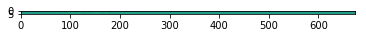

[[0.01091026 0.01091041 0.01091042 ... 0.         0.         0.        ]
 [0.00544325 0.00544324 0.00544325 ... 0.         0.         0.        ]
 [0.00477512 0.00477512 0.00477525 ... 0.         0.         0.        ]
 [0.00659833 0.00659832 0.0065983  ... 0.         0.         0.        ]
 [0.00732681 0.00732681 0.00732672 ... 0.         0.         0.        ]
 [0.00611557 0.00611561 0.00611565 ... 0.         0.         0.        ]]
1386


In [109]:
A_t = net.l1.weight.data.numpy()
A_diff = A_t - A
plt.imshow(A_diff)
plt.show()
print(A_diff)
print(np.count_nonzero(A_diff))

In [112]:
e_lkhds = []
e_lkhds_fault = []

f_lkhds = []
f_lkhds_fault = []

for i in range(X_med_poly.shape[1]-1):  #arbitrary time of year
    e_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[0])
    e_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[0])
    
    f_lkhds.append(np.power(A.dot(X_med_poly[:,i]) - Y_med[:,i],2)[1])
    f_lkhds_fault.append(np.power(A.dot(X_med_poly_fault[:,i]) - Y_med_fault[:,i],2)[1])

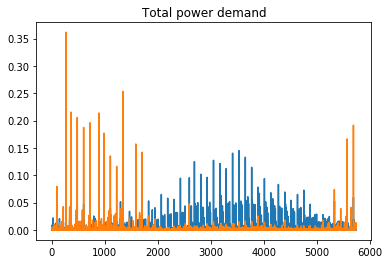

In [113]:
plt.title("Total power demand")
plt.plot(e_lkhds_fault)
plt.plot(e_lkhds)
plt.show()

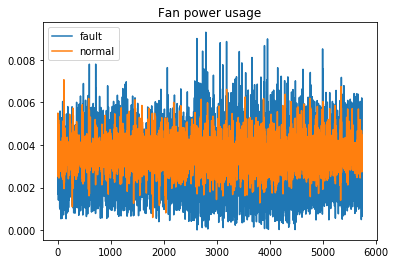

In [114]:
plt.title("Fan power usage")
plt.plot(f_lkhds_fault, label="fault")
plt.plot(f_lkhds, label="normal")
plt.legend()
plt.show()

### Large Office Building

In [ ]:
#building specific var names
zone_temp_inds = [889,890,891]

with open(datapath + "refbuild_largeoffice/seattle/RefBldgLargeOfficeNew2004_Chicago.eso") as d:
    lines = d.readlines()
    lines.pop(0)
    data_dict = read_data_dictionary(lines)
    data = parse_lines(lines, data_dict)
    ind_map = {}
    for key, value in data_dict.items():
        if type(value) == list:
            value = value[-1]
        ind_map[value] = key
    
X = np.zeros((len(dep_var_names) + 3, 8760))
U = np.zeros((len(ind_var_names), 8760))
    
for i in range(len(ind_var_names)):
    item = ind_var_names[i]
    ind = ind_map[item]
    if item == 'DayType':
        lis = data[ind]
        out = []
        for val in lis:
            out.append(val.weekday()/7.0)
        arr = np.array(out)
    else:
        arr = np.array(data[ind])
    U[i,:] = arr
    
for j in range(len(dep_var_names)):
    item = dep_var_names[j]
    ind = ind_map[item]
    arr = np.array(data[ind])
    X[j,:] = arr
    
for j in range(3):
    ind = zone_temp_inds[j]
    arr = np.array(data[ind])
    X[j+len(dep_var_names),:] = arr

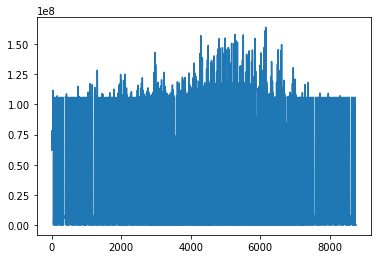

In [68]:
plt.plot(data[2051])
plt.show()

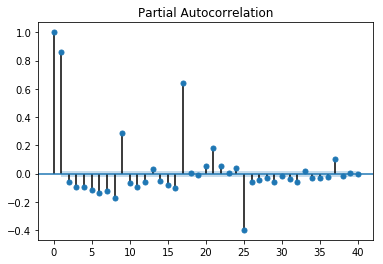

In [69]:
plot_pacf(data[2051], lags=40, alpha=0.05)
plt.show()

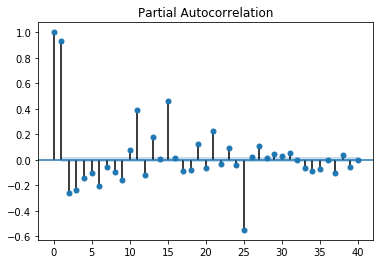

In [70]:
plot_pacf(data[12], lags=40, alpha=0.05)
plt.show()

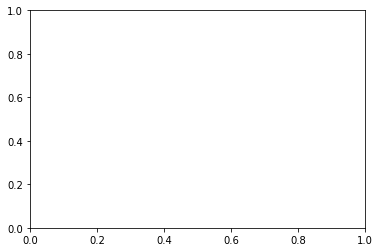

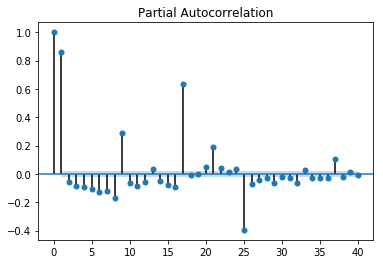

In [72]:
plot_pacf(data[3042], lags=40, alpha=0.05)
plt.show()

## SEB

In [39]:
def read_file_timestamp(strin):
    out = datetime.datetime.strptime(strin, '%Y-%m-%dT%H:%M:%S')
    return(out)

def file_name_from_timestamp(dtobj):
    out = datetime.datetime.strftime(dtobj, "%Y-%m-%d")
    return(out)

def read_volttron_file(fobj, col=1):
    p = []
    lines = fobj.readlines()
    lines.pop(0)
    for line in lines:
        p.append(float(line.strip().split(",")[col]))
    return(p)

def utc_offset(data_list):
    first = data_list[0:480]
    last = data_list[480:]
    return(last + first)

def to_celsius(fah):
    c = (fah - 32.0)/1.8
    return(c)

def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def mean_minute_blocks(arr, minutes):
    output = []
    for i in range(int(len(arr)/minutes)):
        output.append(np.mean(arr[i*minutes:(i+1)*minutes]))
    return(output)

filedates = []
for i in range(21,27): #day 27 is missing data
    filedates.append(file_name_from_timestamp(datetime.datetime(year=2018, month=6, day=i)))
    
weekend = [2,3]
weekdays = [0,1,4,5]

#SEB_months = ["March", "April", "May", "June", "July", "August", "September", "October"]
SEB_months = ["June"]

In [51]:
datadir = "/home/chase/projects/buildnn/data/PNNL/SEB/"

powerdata = []
file_lengths = []

for m in SEB_months:
    csv_files = os.listdir(datadir + "/" + m + "/ELECTRIC_METER/WholeBuildingDemand/")
    for f in csv_files:
        p = []
        with open(datadir + "/" + m + "/ELECTRIC_METER/WholeBuildingDemand/" + f, "r") as d:
            lines = d.readlines()
            file_lengths.append(len(lines))
            lines.pop(0)
            for line in lines:
                p.append(float(line.strip().split(",")[1]))
            powerdata.append(p)

powerdata = np.asarray(powerdata)

In [52]:
powerdata.shape

(30, 1439)

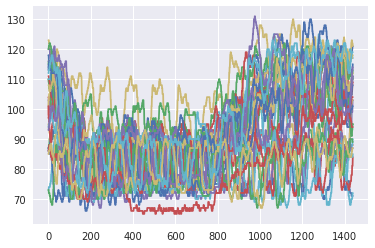

In [54]:
plt.plot(powerdata.T)
plt.show()

In [61]:
airunits = ["AHU1", "AHU2", "AHU3", "AHU4"]
airvars = ["ExhaustFanPower", "OutdoorAirTemperature", "SupplyFanPower"]
vavvars = ["ZoneCoolingTemperatureSetPoint", "ZoneTemperature", "ZoneHeatingTemperatureSetPoint"]

ahudata = {}
vavdata = {}

for M in SEB_months:
    for a in airunits:
        ahudata[a] = {}
        msrmnts = os.listdir(datadir + M + "/" + a)
        for m in msrmnts:
            if m in airvars:
                ahudata[a][m] = []
                filedates = os.listdir(datadir + M + "/" + a + "/" + m + "/")
                for f in filedates:
                    with open(datadir + M + "/" + a + "/" + m + "/" + f, 'r') as d:
                        ahudata[a][m].append(utc_offset(read_volttron_file(d)))
            if m[0:3] == "VAV" and (m[-1] != "A" and m[-1] != "B" and m[-1] != "S" and m[-1] != "Y"):
                vavdata[m] = {}
                for v in vavvars:
                    vavdata[m][v] = []
                    filedates = os.listdir(datadir + M + "/" + a + "/" + m + "/" + v)
                    for f in filedates:
                        with open(datadir + M + "/" + a + "/" + m + "/" + v + "/" + f, 'r') as d:
                            vavdata[m][v].append(utc_offset(read_volttron_file(d)))

        for m in ahudata[a]:
            ahudata[a][m] = np.asarray(ahudata[a][m])

        for v in vavdata:
            for mv in vavdata[v]:
                vavdata[v][mv] = np.asarray(vavdata[v][mv])

In [59]:
filedates

['MaximumZoneAirFlow',
 'ZoneReheatAirFlow',
 'MinimumZoneAirFlow',
 'DeviceOverrideCooling']